<a href="https://colab.research.google.com/github/francescopatane96/Bioactivity-prediction-with-ML/blob/main/filtering_unwanted_substructures3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unwanted substructures:
substructures can be reactive or toxic or they can interfere with certain assays. Filtering unwanted substructures can support assembling more efficient screening libraries, which can save time and resources.

Examples of such unwanted features are nitro groups (mutagenic), sulfates and phosphates (likely resulting in unfavorable pharmacokinetic properties), 2-halopyridines and thiols (reactive). 

Pan Assay Interference Compounds (PAINS):
PAINS are compounds that often occur as hits in HTS even though they actually are false positives. PAINS show activity at numerous targets rather than one specific target.

In [1]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 395 kB/s 


In [2]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [4]:
# load data from Talktorial T2
TNFB_data = pd.read_csv(
    "TNFB_compounds_lipinski.csv",
    index_col=0,
)
# Drop unnecessary information
print("Dataframe shape:", TNFB_data.shape)
TNFB_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
TNFB_data.head()

Dataframe shape: (49, 11)


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,ro5_fulfilled
0,CHEMBL336546,50.0,nM,O=C(Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1)c1cnc(Cl)nc1...,7.301030,"<img data-content=""rdkit/molecule"" src=""data:i...",True
1,CHEMBL131636,170.0,nM,CCCCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C...,6.769551,"<img data-content=""rdkit/molecule"" src=""data:i...",True
2,CHEMBL134490,280.0,nM,CCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C(F...,6.552842,"<img data-content=""rdkit/molecule"" src=""data:i...",True
3,CHEMBL135133,380.0,nM,O=C(Nc1ccc(C(F)(F)F)cc1)c1cnc(Cl)nc1C(F)(F)F,6.420216,"<img data-content=""rdkit/molecule"" src=""data:i...",True
4,CHEMBL334485,500.0,nM,O=C(Nc1cc(Cl)cc(Cl)c1)c1cnc(Cl)nc1C(F)(F)F,6.301030,"<img data-content=""rdkit/molecule"" src=""data:i...",True


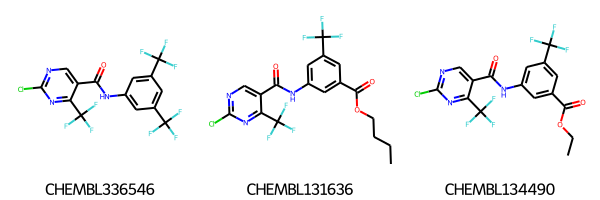

In [5]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(TNFB_data, smilesCol="smiles")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(TNFB_data.head(3).ROMol),
    legends=list(TNFB_data.head(3).molecule_chembl_id),
)

Filter for PAINS

In [6]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [7]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(TNFB_data.iterrows(), total=TNFB_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
TNFB_data = TNFB_data.loc[clean]  # keep molecules without PAINS

  0%|          | 0/49 [00:00<?, ?it/s]

In [8]:
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(TNFB_data)}")

Number of compounds with PAINS: 5
Number of compounds without PAINS: 44


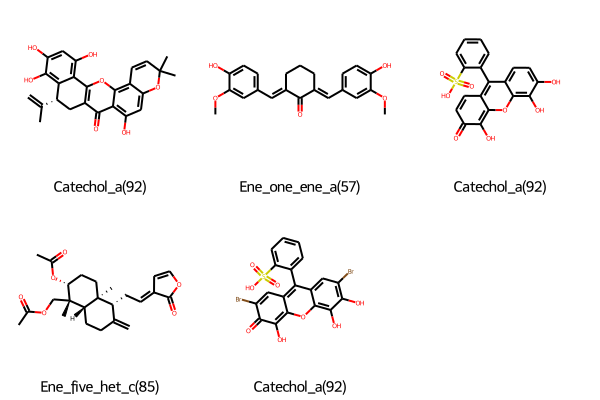

In [10]:
Chem.Draw.MolsToGridImage(
    list(matches.head(5).rdkit_molecule),
    legends=list(matches.head(5)["pains"]),
)

Filter and highlight unwanted substructures

In [16]:
substructures = pd.read_csv("unwantedSubstructures.csv", sep="\s+")
substructures["rdkit_molecule"] = substructures.smart.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))

Number of unwanted substructures in collection: 104


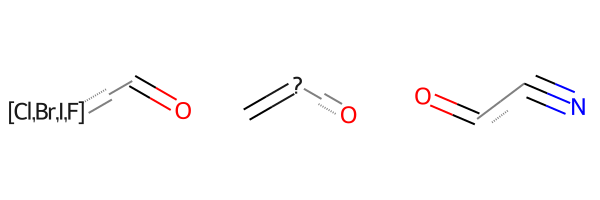

In [23]:
Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecule.tolist()[2:5],
    
)

In [25]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(TNFB_data.iterrows(), total=TNFB_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
TNFB_data = TNFB_data.loc[clean]

  0%|          | 0/44 [00:00<?, ?it/s]

In [26]:
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(TNFB_data)}")

Number of found unwanted substructure: 37
Number of compounds without unwanted substructure: 19


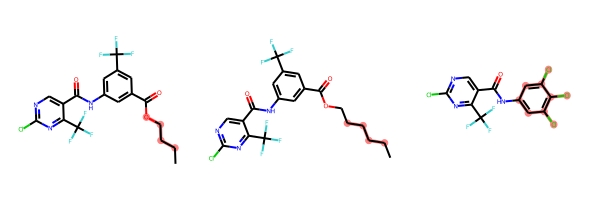

In [28]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    
)

Substructure statistics

In [34]:

group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

NameError: ignored